In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from pylab import rcParams
rcParams['figure.figsize'] = 13, 4

In [ ]:
from google.colab import files
uploaded = files.upload()
df = uploaded
df = pd.read_csv('air_dataset_time.csv')
df.head()

In [ ]:
df.set_index('Datetime',inplace= True)

KeyError: ignored

In [ ]:
ts = df['T'].loc['2004-06-10':'2004-07-01']

In [ ]:
index = pd.date_range(start=ts.index[0], end=ts.index[len(ts)-1], freq='h')
index

DatetimeIndex(['2004-06-10 00:00:00', '2004-06-10 01:00:00',
               '2004-06-10 02:00:00', '2004-06-10 03:00:00',
               '2004-06-10 04:00:00', '2004-06-10 05:00:00',
               '2004-06-10 06:00:00', '2004-06-10 07:00:00',
               '2004-06-10 08:00:00', '2004-06-10 09:00:00',
               ...
               '2004-06-30 14:00:00', '2004-06-30 15:00:00',
               '2004-06-30 16:00:00', '2004-06-30 17:00:00',
               '2004-06-30 18:00:00', '2004-06-30 19:00:00',
               '2004-06-30 20:00:00', '2004-06-30 21:00:00',
               '2004-06-30 22:00:00', '2004-06-30 23:00:00'],
              dtype='datetime64[ns]', length=504, freq='H')

In [ ]:
def select_dayly(x):
  a = []
  for i in range(len(x)):
    if i % 24 == 0:
      a.append(x[i])
  return a

In [ ]:
ts_d = select_dayly(ts)

In [ ]:
ts_d = np.array(ts)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

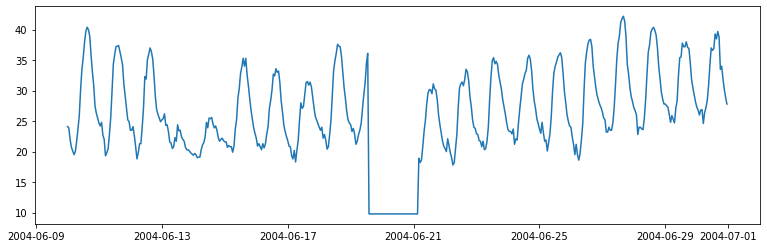

In [ ]:
ts = pd.Series(ts_d, index)
plt.plot(ts)
plt.savefig("te.png")
files.download("te.png") 
plt.show()

# Transformation

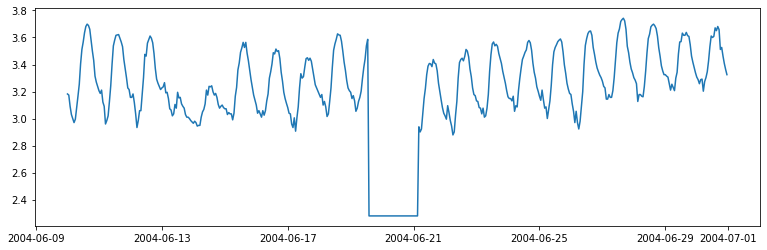

In [ ]:
ts_log = pd.Series(np.log(ts), index=ts.index)
plt.plot(ts_log)
plt.show()

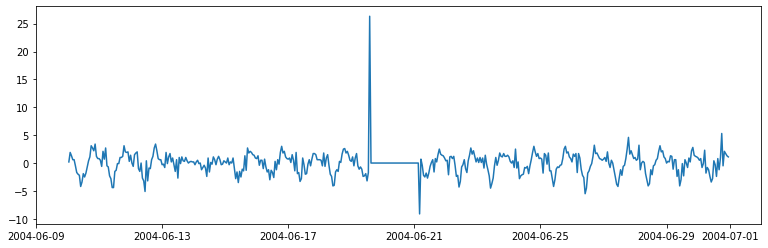

In [ ]:
ts_diff = pd.Series(ts[:-1].values - ts[1:].values, index=ts.index[1:])
plt.plot(ts_diff)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

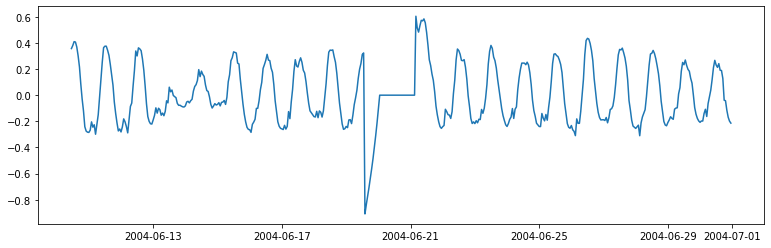

In [ ]:
window = 12
ts_log_mov_diff = pd.Series(ts_log - ts_log.rolling(window, center=False).mean(), index=ts.index)
plt.plot(ts_log_mov_diff)
plt.savefig("trasf.png")
files.download("trasf.png") 
plt.show()

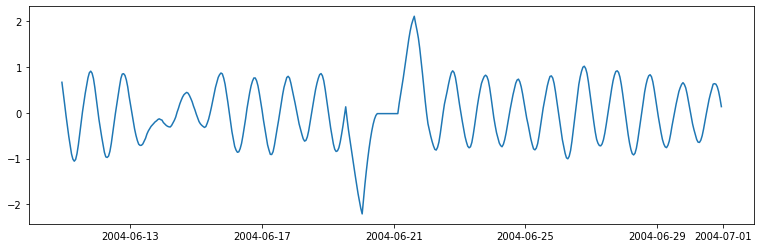

In [ ]:
w =12
plt.plot(((ts_log_mov_diff - ts_log_mov_diff.mean())/ts_log_mov_diff.std()).rolling(window=w).mean())
plt.show()

# Autocorrelation and partial autocorrelation




In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

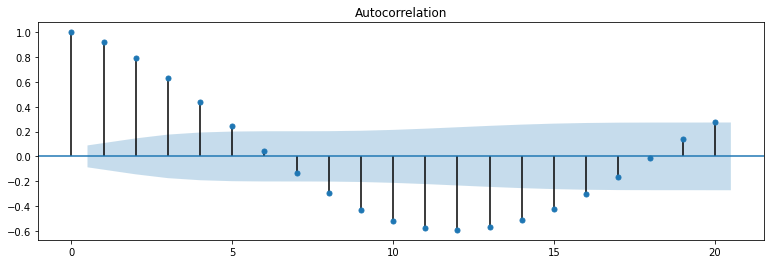

In [ ]:
plot_acf(ts_log_mov_diff.values[11:], lags=20)
plt.savefig("auto.png")
files.download("auto.png") 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

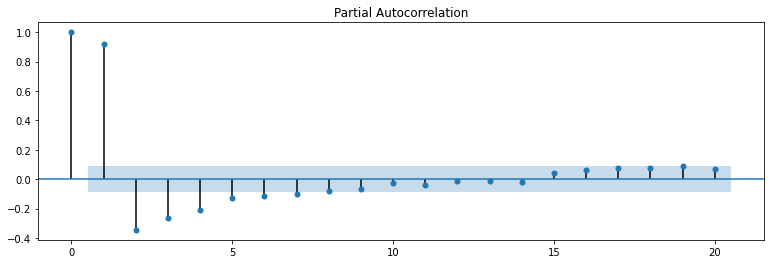

In [ ]:
plot_pacf(ts_log_mov_diff.values[11:], lags=20)
plt.savefig("pauto.png")
files.download("pauto.png") 
plt.show()

# Check stationarity

The Augmented Dickey-Fuller unit root test (http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).
Estimates whether the time series has a time-dependent structure (non-stationary, i.e. affected by trend, seasonality and other phenomena that make the statistics of the time series to vary in time) or not (stationary), which are related to (though quite different from) periodicity and autocorrelation.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
dftest = adfuller(ts, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.718900
p-value                          0.421402
#Lags Used                      18.000000
Number of Observations Used    485.000000
Critical Value (1%)             -3.443905
Critical Value (5%)             -2.867518
Critical Value (10%)            -2.569954
dtype: float64


In [ ]:
dftest = adfuller(ts_log_mov_diff.values[30:], autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -9.631640e+00
p-value                        1.606344e-16
#Lags Used                     7.000000e+00
Number of Observations Used    4.660000e+02
Critical Value (1%)           -3.444461e+00
Critical Value (5%)           -2.867762e+00
Critical Value (10%)          -2.570084e+00
dtype: float64


# Exponential smoothing

In [ ]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

In [ ]:
print(len(ts))
len(ts) * 9/10

504


453.6

# TS after transformation

In [ ]:
from statsmodels.tsa.arima_model import ARMAResults 

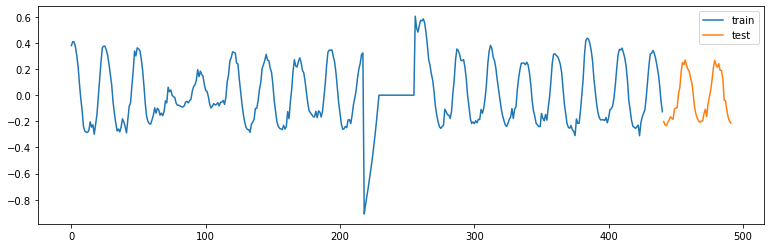

In [ ]:
split_index = 453
train, test = ts_log_mov_diff.iloc[12:split_index], ts_log_mov_diff.iloc[split_index:]

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.legend()
plt.show()

Holt's-Winter's Seasonal Method

Extend Holt's method to capture seasonality

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

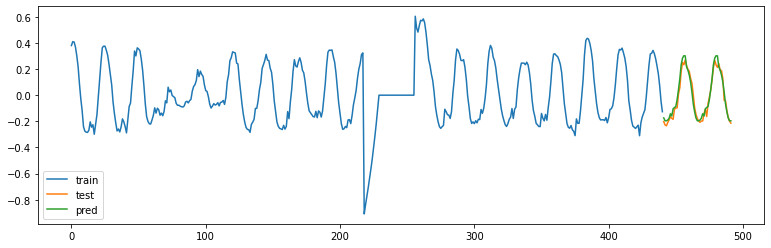

MAE 0.031
RMSE 0.038
MAD 0.024
R2 0.951
MAPE 0.349
MAXAPE 2.837
TAPE 17.815


In [ ]:
seasonal_periods=24

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods,trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.savefig("exp.png")
files.download("exp.png") 
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

# Autoreg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

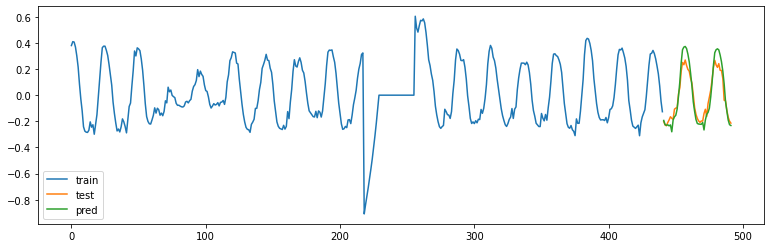

MAE 0.055
RMSE 0.069
MAD 0.046
R2 0.843
MAPE 0.388
MAXAPE 3.918
TAPE 19.791


In [ ]:
sarimax = SARIMAX(train, order=(2,0,0), seasonal_order=(2, 1, 0, 24)).fit(disp=False)   
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.savefig("reg.png")
files.download("reg.png") 
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

In [ ]:
print(sarimax.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  441
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                 473.296
Date:                            Tue, 24 Nov 2020   AIC                           -936.591
Time:                                    17:49:39   BIC                           -916.146
Sample:                                06-10-2004   HQIC                          -928.526
                                     - 06-28-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1083      0.022     50.509      0.000       1.065       1.151
ar.L2         -0.2245      0.034   